In [71]:
%matplotlib inline
# imports required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynetlogo
import numpy as np
import sys
import datetime
sys.path.append('../')
from matplotlib import cm
import time
from ecohydr_mod import EcoHyd

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

yearData = get_yearly_temp("./new_temp_data.csv", 10)

In [3]:
def setUpNetLogoModel(leadFarmers, desperation, jealousy, grace):
    # think this is for the GUI idk?
    sns.set_style("white")
    sns.set_context("talk")

    # starts a NetLogo link, point the netlogo home path to where you have it installed on your machine
    netlogo = pynetlogo.NetLogoLink(
        gui=False,
        netlogo_home="/Volumes/NetLogo 6.3.0/NetLogo 6.3.0"
    )

    # loads a .nlogo model from provided path
    netlogo.load_model("./modelv3.nlogo")

    # runs the model setup command
    netlogo.command("setup")

     # sets globals
    globals = "update-globals " + str(leadFarmers) + " " + str(desperation) + " " + str(jealousy) + " " + str(grace)
    netlogo.command(globals)
    

    return netlogo

In [4]:
def reportsToDataFrame(netlogo):
    # gets field attributes and puts it in a data frame
    fieldAttributes = netlogo.report("get-info")
    sorted_list = sorted(fieldAttributes, key=lambda x: (-x[1],x[0]))
    fieldData = pd.DataFrame(columns=["who", "xcor","ycor","owner-id","implements-WSA", "owner-knows-WSA", "yield"], data=sorted_list)
    return fieldData

In [5]:
def convertWSAToNPArray(data):
    # sets bool into correct format to pass to hydrology model
    emptynp = np.empty((51,51))
    for i in range(0,51):
        for j in range(0,51):
            ycorFromIndex = i * -1 + 25
            xcorFromIndex = j - 25
            emptynp[i][j]= data.loc[(data['ycor'] == ycorFromIndex) & (data['xcor'] == xcorFromIndex)]["implements-WSA"].iloc[0]
    return emptynp

In [6]:
def convertHydrologyToDF(hydrologyArray, data):
    # method converts the hydrology model output into a pandas dataframer
    # 2 is the placeholder to multiply the biomass to get yield
    hydrologyData = data.copy()
    hydrologyData["yield"] = hydrologyArray.reshape((2601,1))
    return hydrologyData

In [7]:
#set climate configurations
current_clim={
        #------------------#
        # dry season dates #
        'canicula_start':0,
        'canicula_end':140, 
        'canicula_start_expected':0,
        'canicula_end_expected':140, 
        #----------------#
        # rainfall stats #
        # Times are all in hours.
        'mean_interstorm_wet':4*24,
        'mean_storm_wet':2*24,
        'mean_raindpth_wet':10,
        'mean_interstorm_dry':10*24,
        'mean_storm_dry':0.5*24,
        'mean_raindpth_dry':1,
        #-------------------#
        # temperature shift #
        'tempshift':np.array(365*[0.])
    }

#have two plausible versions of this that we switch between.

warm_clim={
        #------------------#
        # dry season dates #
        'canicula_start':0,
        'canicula_end':160, 
        'canicula_start_expected':0,
        'canicula_end_expected':140, 
        #----------------#
        # rainfall stats #
        # Times are all in hours.
        'mean_interstorm_wet':8*24,
        'mean_storm_wet':3*24,
        'mean_raindpth_wet':15,
        'mean_interstorm_dry':10*24,
        'mean_storm_dry':0.5*24,
        'mean_raindpth_dry':1,
        #-------------------#
        # temperature shift #
        'tempshift':np.array(365*[2.])
    }

no_desp_scen= [0,5,3, "No Desperation"]
high_jealousy_tolerance_scen = [5,10,3, "High Jealousy Tolerance"]
low_jealousy_tolerance_scen = [5,2,3, "Low Jealousy Tolerance"]



year: 0
year: 1
year: 2
year: 3
year: 4
year: 5
year: 6
year: 7
year: 8
year: 9
year: 10
year: 11
year: 12
year: 13
year: 14
year: 15
year: 16
year: 17
year: 18
year: 19
year: 20


/var/folders/qw/dj7vjbyd6kb8q83q6chjb9m00000gn/T/ipykernel_50533/2306156282.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


year: 21
year: 22
year: 23
year: 24
year: 25
year: 26
year: 27
year: 28
year: 29


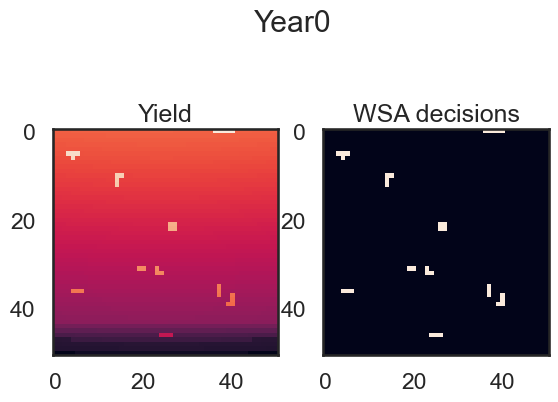

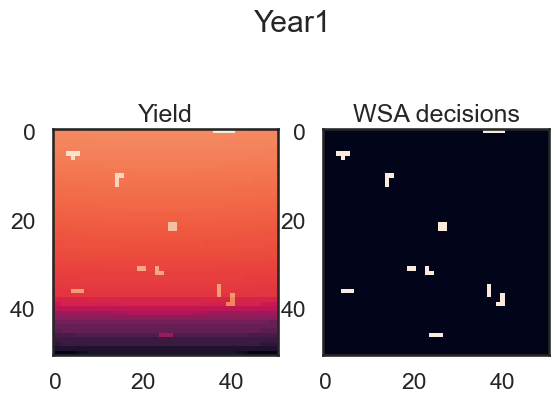

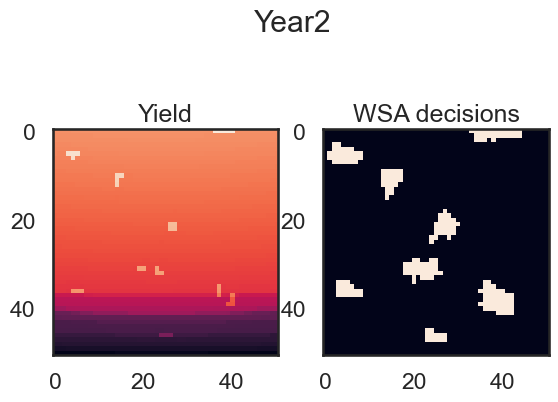

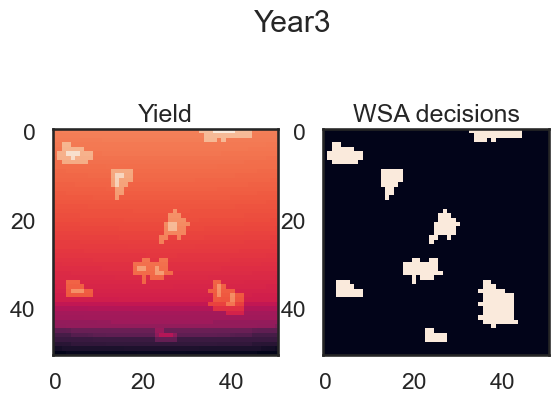

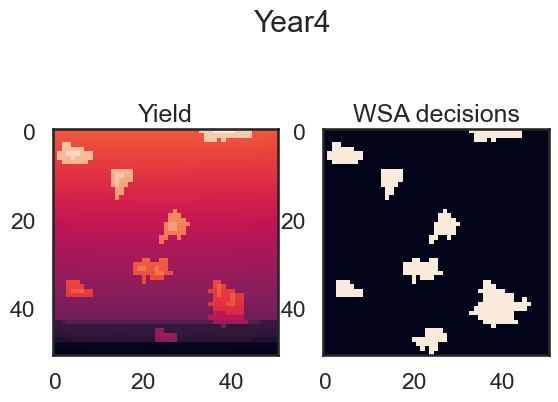

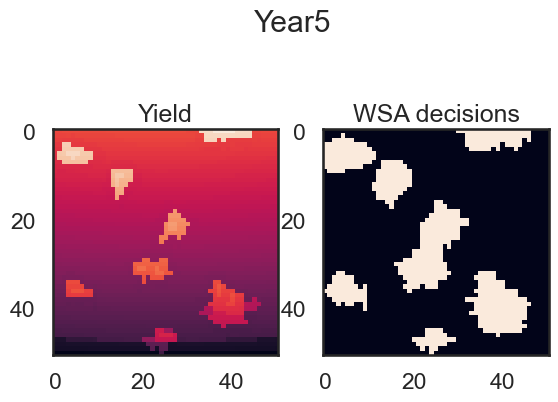

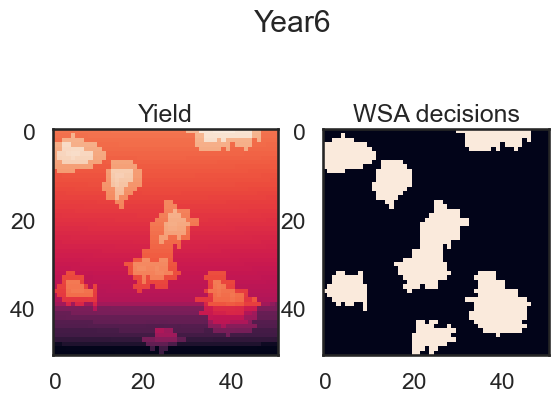

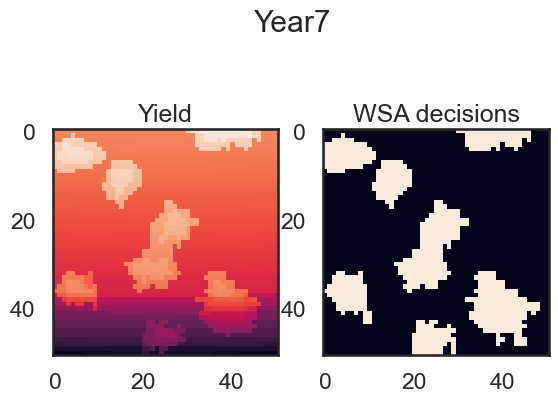

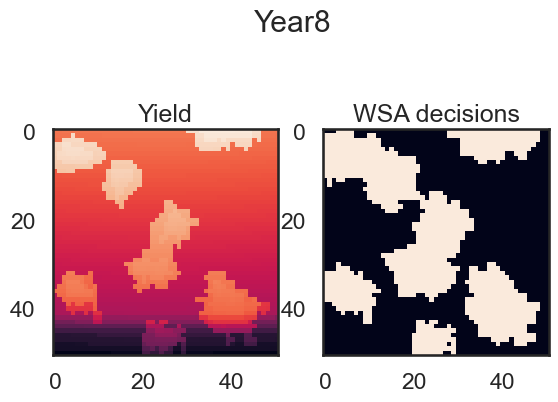

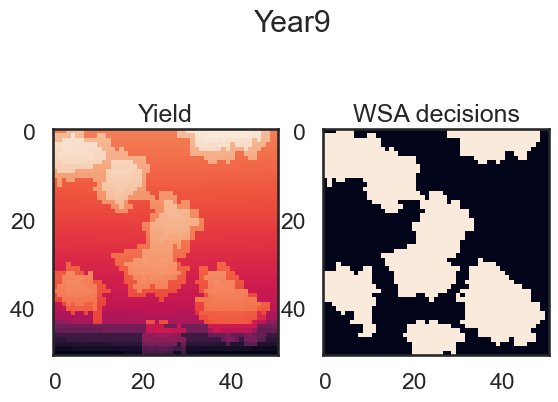

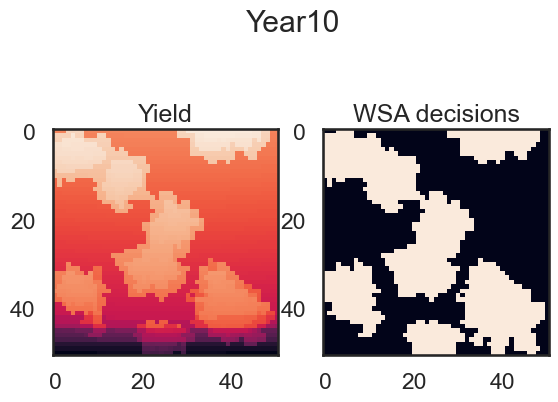

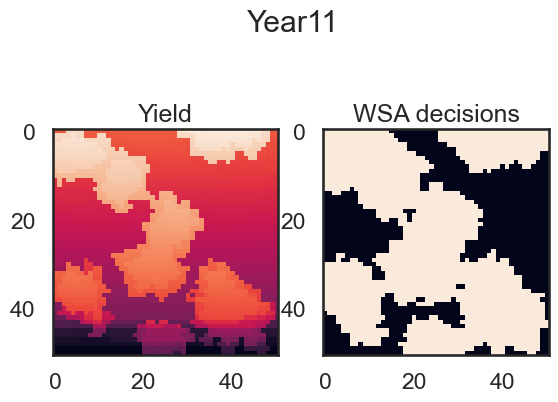

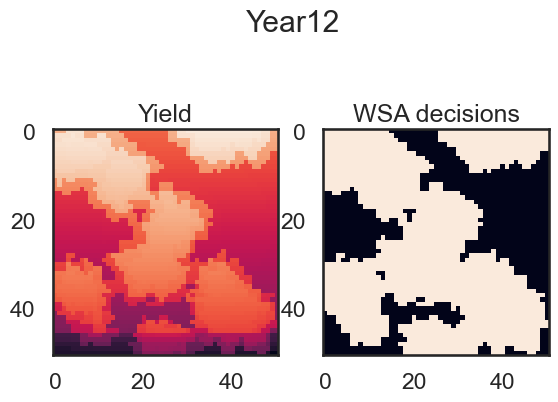

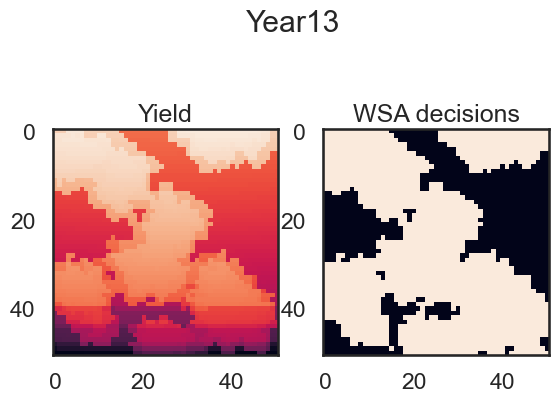

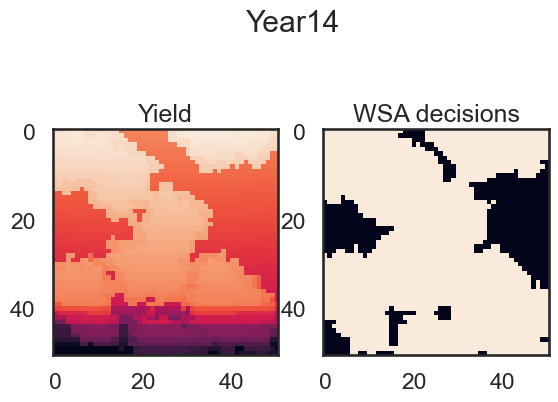

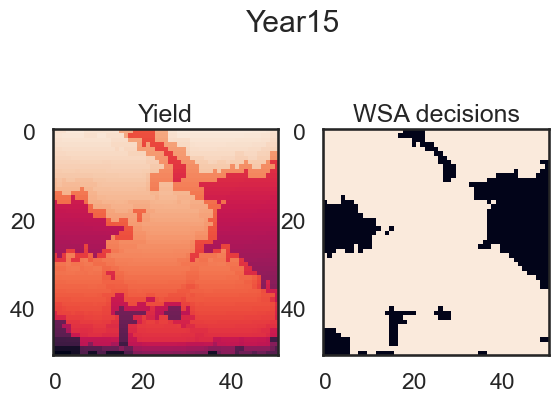

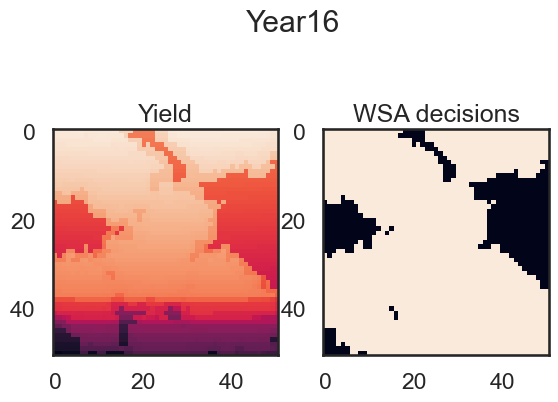

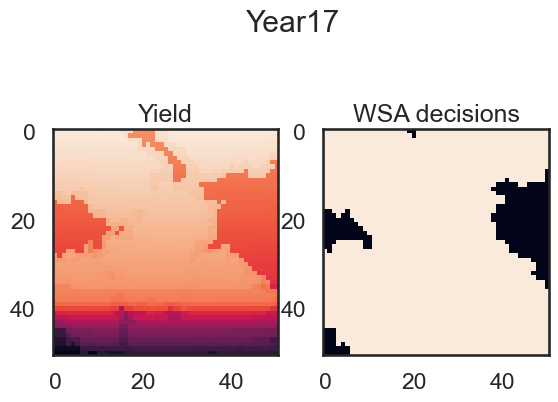

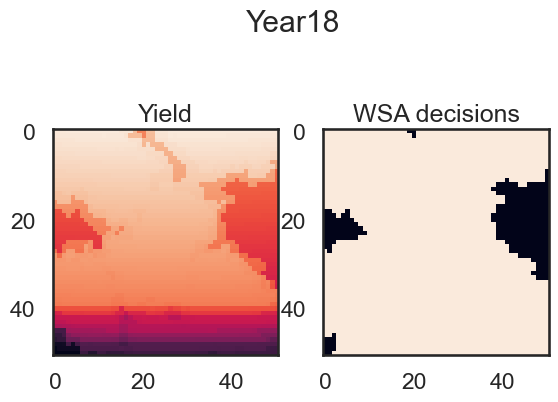

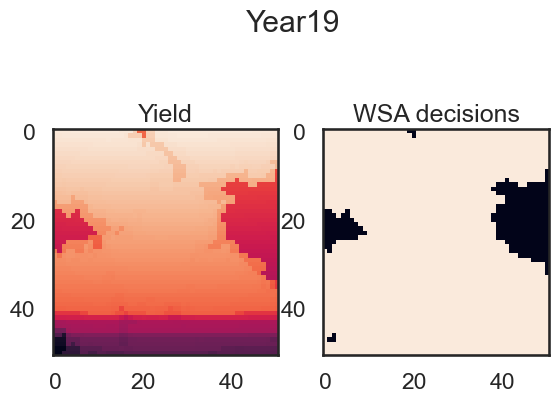

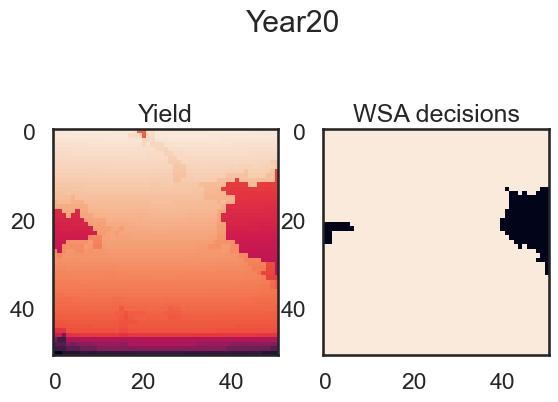

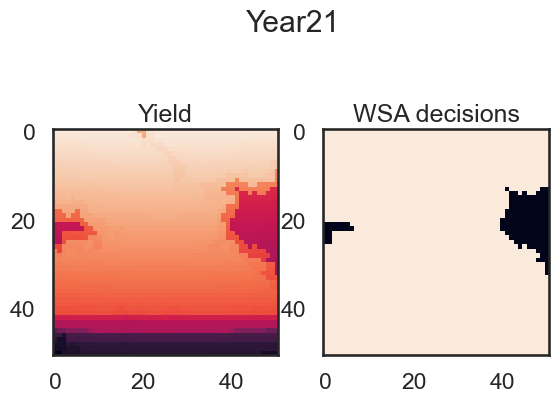

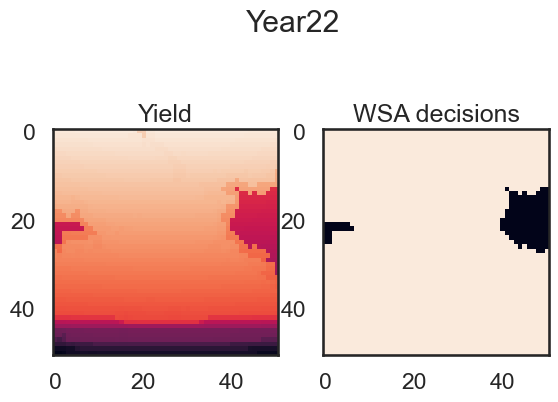

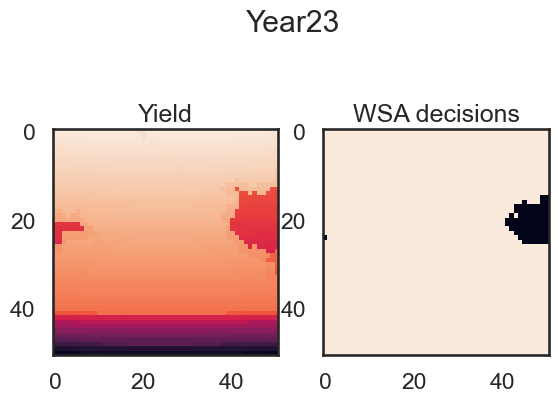

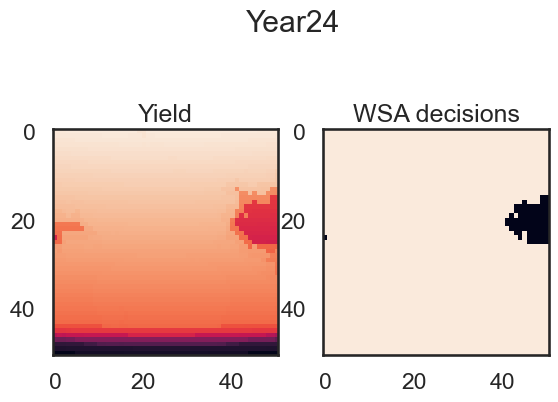

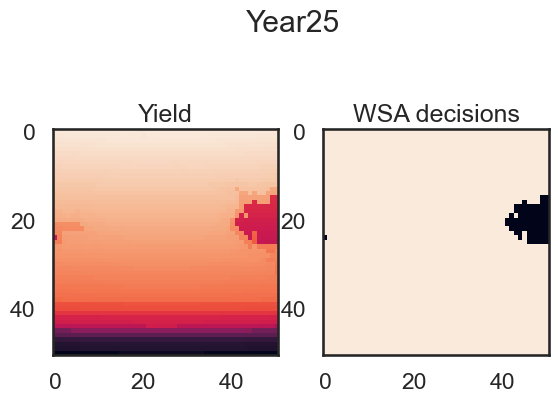

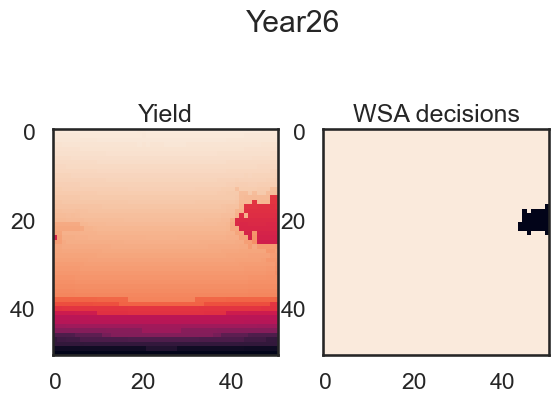

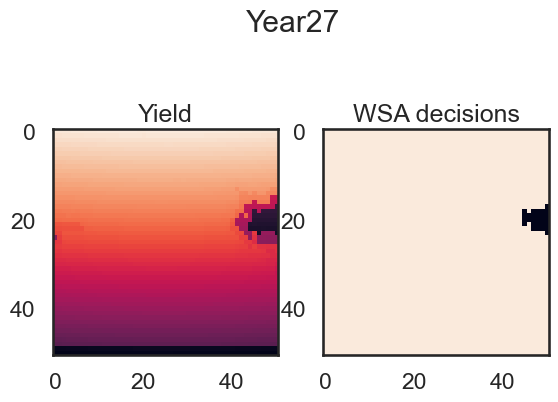

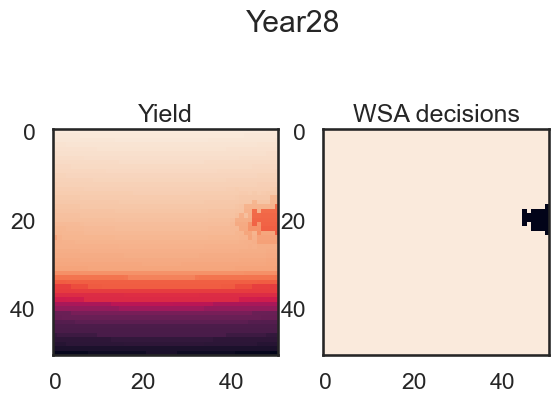

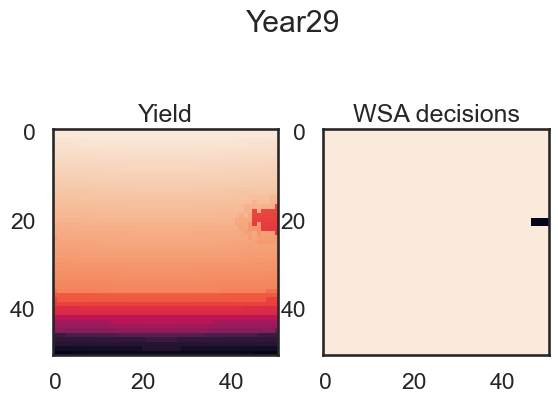

In [47]:
def fullModelRun(climate, leadFarmers, social, input_csv_path, no_of_years):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, social[0], social[1], social[2])

    # this will record all field attributes throughout the simulation - need to add year index to differentiate
    baseFieldData = reportsToDataFrame(netlogo)

    returnedData = baseFieldData.copy()
    
    baseFieldData["Year"] = 0

    WSA_records = []

    
    #get input temperature data
    avg, maxi, mini = get_yearly_temp(input_csv_path, no_of_years)
    avg = np.array(avg)
    maxi = np.array(maxi)
    mini = np.array(mini)

    Ecohyd_model = EcoHyd(climate, 20, 26, 23)

    #--------------------------------------------#
    # let hydrology model spin up for five years #
    for i in range(0,5):
        #just use same initial WSA array for each year
        WSA_array = convertWSAToNPArray(returnedData)
        _,_ = Ecohyd_model.stepper(WSA_array, avg[0]+climate['tempshift'], maxi[0]+climate['tempshift'], mini[0]+climate['tempshift'])

    #---------------------------------#
    # actual coupled model loop whooo #
    for year in range(0, no_of_years):
        print("year:", year)

        # converts the usingWSA bool for each field into an NP array
        WSA_array = convertWSAToNPArray(returnedData)
        WSA_records.append([WSA_array])

        biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[year]+climate['tempshift'], maxi[year]+climate['tempshift'], mini[year]+climate['tempshift'])

        #record outputs for yearly rainfall
        cum_rainfall = np.cumsum(Ecohyd_model.rain_tseries[(year)*365:(year+1)*365])[-1]

        fig, ax = plt.subplots(1, 2)
        title_string = "Year" + str(year)
        fig.suptitle(title_string)
        ax[0].imshow(np.reshape(biomass_harvest,(51,51)))
        ax[0].set_title("Yield")
        ax[1].imshow(WSA_array)
        ax[1].set_title("WSA decisions")

        returnedData.sort_values(by=['ycor', 'xcor'], ascending=[False, True], inplace=True)

        # converts the updated yields to the dataframe
        hydrologyData = convertHydrologyToDF(biomass_harvest,returnedData)
        
        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(hydrologyData, "field")

        # runs one step of social model
        netlogo.command("farming-year")

        # converts field data to a df
        returnedData = reportsToDataFrame(netlogo)

        dataToRecord = returnedData.copy()
        
        dataToRecord["Year"] = year + 1

        dataToRecord["TotalYearRainfall"] = cum_rainfall

        # adds this years results to the dataframe
        baseFieldData = pd.concat([baseFieldData, dataToRecord], ignore_index=True)

    summarisedData = baseFieldData.groupby(["owner-id","Year"]).agg({'xcor':'mean','ycor':'mean','implements-WSA':'mean','owner-knows-WSA':'mean', 'yield':'sum', 'who':'count'}).reset_index()
    summarisedData.rename(columns={'owner-id':'FarmerID', 'xcor':'MeanXCor', 'ycor':'MeanYCor', 'implements-WSA':'ImplementingWSA','owner-knows-WSA':'KnowsWSA','yield':'TotalYield','who':'NumberofFields'})

    summarisedData["LeadFarmers"] = leadFarmers
    summarisedData["SocialScenario"] = social[3]
    if climate['mean_raindpth_wet'] == 10:
        summarisedData["ClimateScenario"] = "Current Climate"
    else:
        summarisedData["ClimateScenario"] = "Warm Climate"
    summarisedData["UniqueID"] = str(datetime.datetime.now())
    
    # this writes to a csv
    summarisedData.to_csv(path_or_buf="modelOutput", mode = "a", index=False, header = True)
    return summarisedData, WSA_records, biomass_harvest
    
    


# haven't got setup with globals actually working yet, manually change in the NetLogo Code
baseFieldData, WSA_records, biomass_harvest = fullModelRun(current_clim, 10, no_desp_scen,"new_temp_data.csv", 30)

In [48]:
for a in range(0,30):
    b = a - 1
    if b >= 0:
        for c in range(0,51):
            for d in range(0,51):
                print(a, b,c,d)
                WSA_records[a][0][c][d] += WSA_records[b][0][c][d]

1 0 0 0
1 0 0 1
1 0 0 2
1 0 0 3
1 0 0 4
1 0 0 5
1 0 0 6
1 0 0 7
1 0 0 8
1 0 0 9
1 0 0 10
1 0 0 11
1 0 0 12
1 0 0 13
1 0 0 14
1 0 0 15
1 0 0 16
1 0 0 17
1 0 0 18
1 0 0 19
1 0 0 20
1 0 0 21
1 0 0 22
1 0 0 23
1 0 0 24
1 0 0 25
1 0 0 26
1 0 0 27
1 0 0 28
1 0 0 29
1 0 0 30
1 0 0 31
1 0 0 32
1 0 0 33
1 0 0 34
1 0 0 35
1 0 0 36
1 0 0 37
1 0 0 38
1 0 0 39
1 0 0 40
1 0 0 41
1 0 0 42
1 0 0 43
1 0 0 44
1 0 0 45
1 0 0 46
1 0 0 47
1 0 0 48
1 0 0 49
1 0 0 50
1 0 1 0
1 0 1 1
1 0 1 2
1 0 1 3
1 0 1 4
1 0 1 5
1 0 1 6
1 0 1 7
1 0 1 8
1 0 1 9
1 0 1 10
1 0 1 11
1 0 1 12
1 0 1 13
1 0 1 14
1 0 1 15
1 0 1 16
1 0 1 17
1 0 1 18
1 0 1 19
1 0 1 20
1 0 1 21
1 0 1 22
1 0 1 23
1 0 1 24
1 0 1 25
1 0 1 26
1 0 1 27
1 0 1 28
1 0 1 29
1 0 1 30
1 0 1 31
1 0 1 32
1 0 1 33
1 0 1 34
1 0 1 35
1 0 1 36
1 0 1 37
1 0 1 38
1 0 1 39
1 0 1 40
1 0 1 41
1 0 1 42
1 0 1 43
1 0 1 44
1 0 1 45
1 0 1 46
1 0 1 47
1 0 1 48
1 0 1 49
1 0 1 50
1 0 2 0
1 0 2 1
1 0 2 2
1 0 2 3
1 0 2 4
1 0 2 5
1 0 2 6
1 0 2 7
1 0 2 8
1 0 2 9
1 0 2 10
1 0 2 11
1 0 

In [44]:
WSApictures[29][0][0][0]

32768.0

In [55]:
WSA_records[29]

[array([[ 19.,  19.,  19., ...,  22.,  19.,  19.],
        [ 22.,  22.,  22., ...,  22.,  19.,  19.],
        [ 22.,  22.,  25., ...,  22.,  19.,  19.],
        ..., 
        [ 11.,  11.,  11., ...,  19.,  16.,  16.],
        [ 11.,  11.,  11., ...,  20.,  17.,  16.],
        [ 11.,  11.,  12., ...,  17.,  17.,  17.]])]

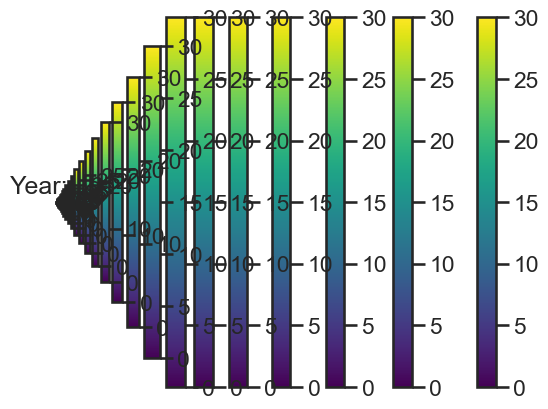

In [85]:
for i in range(0,30):
    plt.imshow(WSA_records[i][0], vmin = 0, vmax = 30, cmap=cm.viridis)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    yearString = "Year: " + str(i)
    plt.title(yearString)
    fileName = "9year" + str(i)
    plt.colorbar()
    plt.savefig(fileName)
    

In [9]:
baseFieldData.loc[(baseFieldData["implements-WSA"] == 0) & (baseFieldData["Year"] == 3) & (baseFieldData["yield"] > 30)]

,owner-id,Year,xcor,ycor,implements-WSA,owner-knows-WSA,yield,who,LeadFarmers,SocialScenario,ClimateScenario,UniqueID
3,0.0,3,18.400000,-2.200000,0.0,0.0,247.813729,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
34,1.0,3,22.333333,-18.333333,0.0,1.0,106.145201,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
65,2.0,3,-1.000000,23.000000,0.0,0.0,379.105694,7,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
96,3.0,3,3.000000,24.000000,0.0,0.0,54.323302,1,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
127,4.0,3,8.500000,11.000000,0.0,0.0,104.106812,2,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
...,...,...,...,...,...,...,...,...,...,...,...,...
24648,795.0,3,15.000000,1.000000,0.0,0.0,50.190881,1,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24679,796.0,3,-6.166667,21.333333,0.0,0.0,323.215543,6,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24710,797.0,3,16.000000,-5.250000,0.0,0.0,196.013462,4,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24741,798.0,3,18.666667,-13.333333,0.0,0.0,131.999726,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953


In [10]:
baseFieldData

,owner-id,Year,xcor,ycor,implements-WSA,owner-knows-WSA,yield,who,LeadFarmers,SocialScenario,ClimateScenario,UniqueID
0,0.0,0,18.400000,-2.200000,0.0,0.0,250.000000,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
1,0.0,1,18.400000,-2.200000,0.0,0.0,252.661075,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
2,0.0,2,18.400000,-2.200000,0.0,0.0,251.136570,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
3,0.0,3,18.400000,-2.200000,0.0,0.0,247.813729,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
4,0.0,4,18.400000,-2.200000,0.0,0.0,247.416978,5,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
...,...,...,...,...,...,...,...,...,...,...,...,...
24795,799.0,26,-20.333333,20.333333,1.0,1.0,183.385829,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24796,799.0,27,-20.333333,20.333333,1.0,1.0,179.314660,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24797,799.0,28,-20.333333,20.333333,1.0,1.0,190.104827,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953
24798,799.0,29,-20.333333,20.333333,1.0,1.0,182.333142,3,10,No Desperation,Current Climate,2023-11-30 09:24:11.396953


In [11]:
biomass_harvest

array([ 62.25360621,  62.26388018,  62.2749925 , ...,  34.23619669,
        34.22795007,  34.21937194])

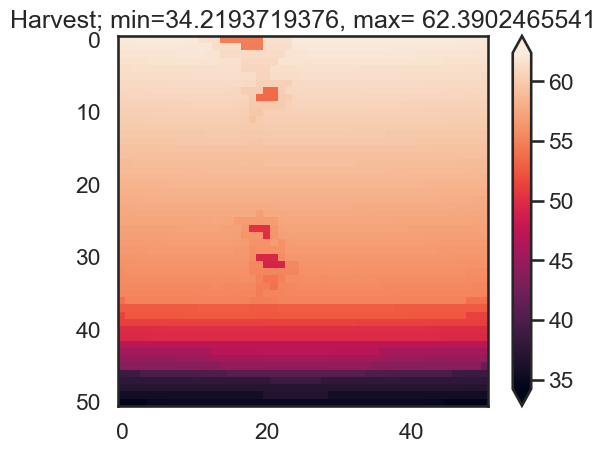

In [12]:
plt.imshow(np.reshape(biomass_harvest, (51,51)))
hmin = np.min(biomass_harvest)
hmax = np.max(biomass_harvest)
plt.title('Harvest; min='+str(hmin)+', max= ' + str(hmax))

plt.colorbar(extend = 'both')

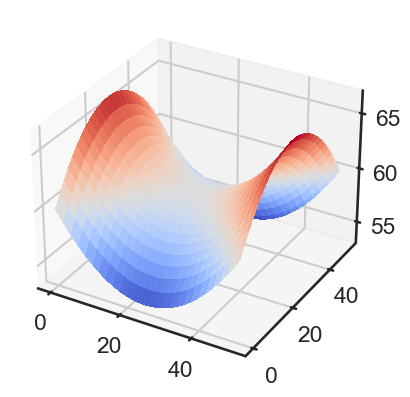

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

# Make data.
X = np.arange(0, 52, 1)
Y = np.arange(0, 52, 1)
X, Y = np.meshgrid(X, Y)
R = 0.01*(X-25)**2 - 0.01*(Y-25)**2 + 60

# Plot the surface.
surf = ax.plot_surface(X, Y, R,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)

plt.show()

In [14]:
print(baseFieldData.loc[baseFieldData["implements-WSA"] == 1].groupby(["Year"]).mean())

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
print(baseFieldData.groupby(["Year", "implements-WSA"]).mean())

TypeError: Could not convert 2023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.374248 to numeric

Text(0.5, 0.98, 'WSA field spread')

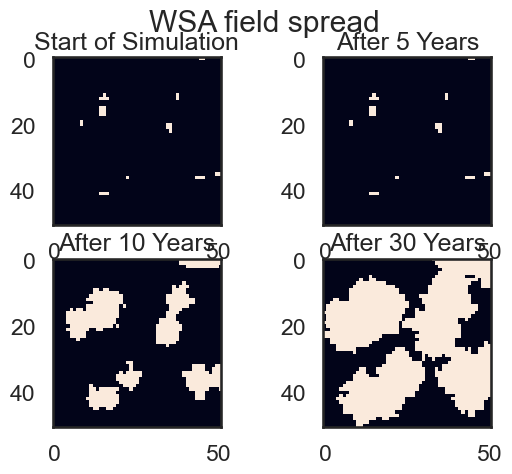

In [ ]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(WSA_records[0][0])
ax[0][0].set_title("Start of Simulation")
ax[0][1].imshow(WSA_records[1][0])
ax[0][1].set_title("After 5 Years")
ax[1][0].imshow(WSA_records[4][0])
ax[1][0].set_title("After 10 Years")
ax[1][1].imshow(WSA_records[9][0])
ax[1][1].set_title("After 30 Years")
plt.suptitle("WSA field spread")

In [ ]:
avgyielddata = baseFieldData.groupby(["Year", "owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"]).mean().reset_index()

nonImp = avgyielddata.loc[avgyielddata["implements-WSA"] == 0]
imp = avgyielddata.loc[avgyielddata["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["yield"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["yield"], label = "Implements WSA")
plt.legend()
plt.title("Average farmer yield by WSA type")

TypeError: Could not convert 2023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.374248 to numeric

Text(0.5, 1.0, 'Number of farmers using each technique')

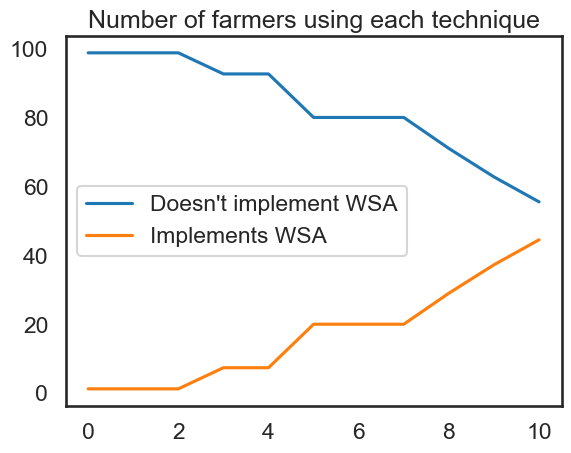

In [ ]:
proportionData = baseFieldData.groupby(["Year","implements-WSA","owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"])["yield"].count().reset_index()

proportionData["percentage"] = proportionData["yield"] / 800 * 100

nonImp = proportionData.loc[proportionData["implements-WSA"] == 0]
imp = proportionData.loc[proportionData["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["percentage"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["percentage"], label = "Implements WSA")
plt.legend()
plt.title("Number of farmers using each technique")

In [ ]:
baseFieldData

,who,xcor,ycor,owner-id,implements-WSA,yield,Year,Lead Farmers,Desperation,Jealousy,Grace Period Length
0,841.0,25.0,-13.0,645.0,0.0,50.000000,0,10,0,2,3
1,978.0,25.0,0.0,301.0,0.0,50.000000,0,10,0,2,3
2,984.0,25.0,-16.0,89.0,0.0,50.000000,0,10,0,2,3
3,1011.0,25.0,8.0,227.0,0.0,50.000000,0,10,0,2,3
4,1142.0,25.0,-19.0,727.0,0.0,50.000000,0,10,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...
28606,2991.0,-25.0,20.0,42.0,0.0,61.208856,10,10,0,2,3
28607,3177.0,-25.0,7.0,468.0,0.0,61.074106,10,10,0,2,3
28608,3182.0,-25.0,14.0,362.0,0.0,61.146991,10,10,0,2,3
28609,3234.0,-25.0,-25.0,733.0,1.0,65.307144,10,10,0,2,3
